In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import talib
import matplotlib.ticker as ticker

In [9]:
# url = "https://yh-finance.p.rapidapi.com/stock/v3/get-chart"

# querystring = {"interval":"1d","symbol":"TSLA","range":"2y","region":"US","includePrePost":"false","useYfid":"true","includeAdjustedClose":"true","events":"capitalGain,div,split"}

# headers = {
#     'x-rapidapi-host': "yh-finance.p.rapidapi.com",
#     'x-rapidapi-key': "4ff38036c9msh6d10bc32423139dp11540bjsn0dbe5c5a8356"
#     }

# response = requests.request("GET", url, headers=headers, params=querystring)

# file = open("tesla2y.txt", "w")
# file.write(response.text)
# file.close()

# print(response.text)
# data = json.loads(response.text)

In [10]:
file = open("tesla2y.txt", "r")
data = json.loads(str(file.read()))

timestamplist = data["chart"]["result"][0]["timestamp"]
calendertime = []
for ts in timestamplist:
    dt = datetime.fromtimestamp(ts)
    calendertime.append(dt.strftime("%m/%d/%Y"))
df = pd.DataFrame()
df['Open'] = data["chart" ]["result"][0]["indicators"]["quote"][0]["open"]
df['Close'] = data["chart"]["result"][0]["indicators"]["quote"][0]["close"]
df['High'] = data["chart"]["result"][0]["indicators"]["quote"][0]["high"]
df['Low'] = data["chart"]["result"][0]["indicators"]["quote"][0]["low"]
df['Volume'] = data["chart"]["result"][0]["indicators"]["quote"][0]["volume"]
df.index = calendertime

df['Return'] = df['Close'].pct_change()

In [11]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False, xaxis_title="Time", yaxis_title="Price")
fig.update_xaxes(nticks=8)
fig.show()

In [12]:
sns.set()
df['EMA_5'] = talib.EMA(df['Close'], timeperiod=5)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
df['EMA_50'] = talib.EMA(df['Close'], timeperiod=50)

<ipython-input-13-96c8dff8fcf0>:9: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



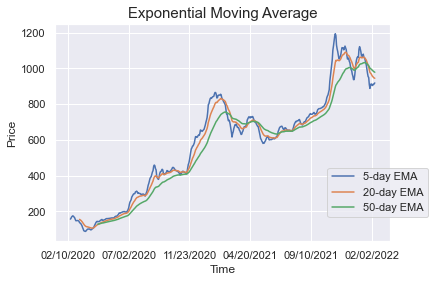

In [13]:
fig, axes = plt.subplots()
df['EMA_5'].plot()
df['EMA_20'].plot()
df['EMA_50'].plot()
fig.legend(labels = ['5-day EMA', '20-day EMA', '50-day EMA'], bbox_to_anchor=(1, 0.4))
axes.set_title("Exponential Moving Average", fontsize=15)
axes.set_ylabel("Price")
axes.set_xlabel("Time")
fig.show()
# fig.savefig("EMA.jpg")

Text(0.5, 0, 'Time')

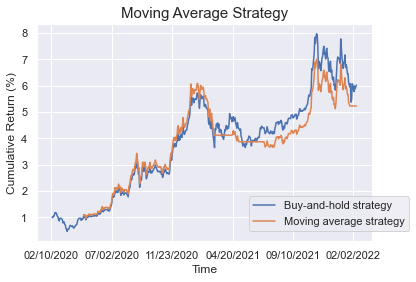

In [14]:
# Buy when the five-period EMA crosses from below to above the 20-period EMA, 
# and the price, five, and 20-period EMAs are above the 50 EMA.
df.loc[((df['EMA_5'] > df['EMA_20']) & (df['Close'] > df['EMA_50']) & (df['EMA_5'] > df['EMA_50']) & 
        (df['EMA_20'] > df['EMA_50'])), 'Position'] = 1

# Sell when the five-period EMA crosses from above to below the 20-period EMA, 
# and both EMAs and the price are below the 50-period EMA.
df.loc[((df['EMA_5'] < df['EMA_20']) & (df['Close'] < df['EMA_50']) & (df['EMA_5'] < df['EMA_50']) & 
        (df['EMA_20'] < df['EMA_50'])), 'Position'] = 0

df['Position'] = df['Position'].fillna(method='ffill')
df['Position'] = df['Position'].shift(1)
df['Strategy Return'] = df['Position']*df['Return']
df['Cumulative Strategy Return'] = (df['Strategy Return'] + 1).cumprod()
df['Buy and Hold'] = (df['Return'] + 1).cumprod()

fig1, axes1 = plt.subplots()
df['Buy and Hold'].plot()
df['Cumulative Strategy Return'].plot()
fig1.legend(labels = ['Buy-and-hold strategy', 'Moving average strategy'], bbox_to_anchor=(1, 0.3))
axes1.set_title("Moving Average Strategy", fontsize=15)
axes1.set_ylabel("Cumulative Return (%)")
axes1.set_xlabel("Time")
# fig1.savefig("EMA_strategy.jpg")

In [15]:
def compute_SR(return_data, r_free = 0.01/252):
    return (return_data.mean() - r_free) / return_data.std() * np.sqrt(252)

print(compute_SR(df['Strategy Return']),compute_SR(df['Return']))

1.826982534684395 1.5855862875659292


In [16]:
split = round(len(df)*0.8)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

In [17]:
def optimisation(data, start = 0.01, end = 1, step = 0.01):    
    result = []
    for signal in np.arange(start, end, step):
        data['Ratio'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
        data['Position'] = np.where(data['Ratio'] > signal, 1, 0)
        data['Position'] = data['Position'].shift(1)
        data['Strategy Return'] = data['Position']*data['Return']
        data['Cumulative Strategy Return'] = (data['Strategy Return'] + 1).cumprod()
        SR = compute_SR(data['Strategy Return'])
        performance = {'CLHL Ratio': signal, 'Sharpe Ratio': SR}
        result.append(performance)
    result = pd.DataFrame(result)
    sorted_result = result.sort_values('Sharpe Ratio', ascending = False)
    return sorted_result
threshold = optimisation(train).iloc[0][0]

In [18]:
def apply_param(data, opt):
    data['Ratio'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
    data['Position'] = np.where(data['Ratio'] > opt, 1, 0)
    data['Position'] = data['Position'].shift(1)
    data['Strategy Return'] = data['Position']*data['Return']
    data['Cumulative Strategy Return'] = (data['Strategy Return'] + 1).cumprod()
    data['Buy and Hold'] = (data['Return'] + 1).cumprod()
    SharpeRatio = compute_SR(data['Strategy Return'])
    return SharpeRatio
print(apply_param(test, threshold), apply_param(train, threshold))

1.978678566409209 1.7411296322104652


1.7411296322104652 1.6914225394499809


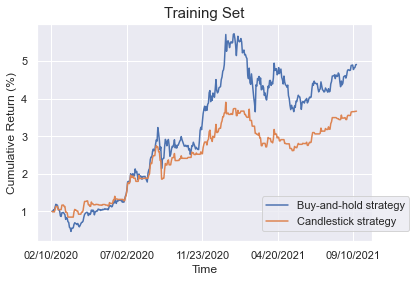

In [19]:
print(compute_SR(train['Strategy Return']), compute_SR(train['Return']))

fig1, axes1 = plt.subplots()
train['Buy and Hold'].plot()
train['Cumulative Strategy Return'].plot()
fig1.legend(labels = ['Buy-and-hold strategy', 'Candlestick strategy'], bbox_to_anchor=(1, 0.3))
axes1.set_title("Training Set", fontsize=15)
axes1.set_ylabel("Cumulative Return (%)")
axes1.set_xlabel("Time")
axes1.xaxis.set_major_locator(ticker.MultipleLocator(100))
# fig1.savefig("training set.jpg")

1.978678566409209 1.1004136853915796


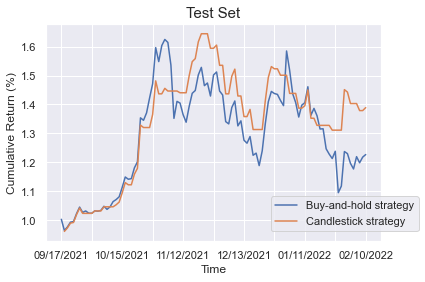

In [20]:
print(compute_SR(test['Strategy Return']), compute_SR(test['Return']))

fig2, axes2 = plt.subplots()
test['Buy and Hold'].plot()
test['Cumulative Strategy Return'].plot()
fig2.legend(labels = ['Buy-and-hold strategy', 'Candlestick strategy'], bbox_to_anchor=(1, 0.3))
axes2.set_title("Test Set", fontsize=15)
axes2.set_ylabel("Cumulative Return (%)")
axes2.set_xlabel("Time")
axes2.xaxis.set_major_locator(ticker.MultipleLocator(10))
# fig2.savefig("test set.jpg")

1.7824429238420076 1.5855862875659292


Text(0.5, 0, 'Time')

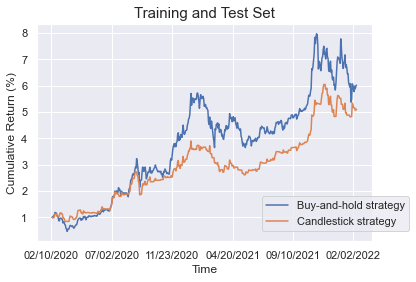

In [21]:
apply_param(df, threshold)
print(compute_SR(df['Strategy Return']), compute_SR(df['Return']))

fig3, axes3 = plt.subplots()
df['Buy and Hold'].plot()
df['Cumulative Strategy Return'].plot()
fig3.legend(labels = ['Buy-and-hold strategy', 'Candlestick strategy'], bbox_to_anchor=(1, 0.3))
axes3.set_title("Training and Test Set", fontsize=15)
axes3.set_ylabel("Cumulative Return (%)")
axes3.set_xlabel("Time")
# fig3.savefig("full history.jpg")